In [1]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [2]:
day = "0802"
name_notebook = day + "-sh_1qm.ipynb"

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X, dtype=ptm.torch.float64) 
target_data = ptm.torch.tensor(Y, dtype=ptm.torch.float64).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation, dtype=ptm.torch.float64)
target_validation = ptm.torch.tensor(Y_validation, dtype=ptm.torch.float64).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.exp_Z(1),
    n_layers = 25,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

In [10]:
str(quantum_layer)

'<my_code.quantum_nodes.circuit object at 0x00000221E22D9690>'

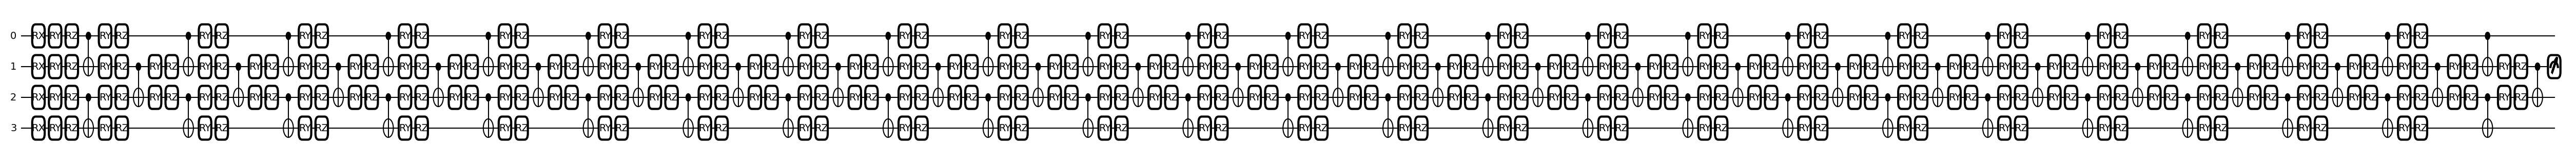

In [11]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [12]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [13]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0])]
layers += [quantum_layer()]
# layers += [nn.Linear(1, 1)]
# layers += [nn.Linear(2, 4), nn.ReLU()]
# layers += [nn.Linear(4, 1)]

In [14]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
    keep_track_params = True,
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [15]:
print(model(input_data[0]).item())
print(model(input_data[1]).item())

0.005036722254243897
0.006703712312189913


In [16]:
# train the model
model.train(
    num_epochs = 2,                
    batch_size = 32,
)

Epoch [0/2], Loss: 0.9889, Loss validation: 0.9845
	 Validation string, 	 i: 0; 	 prediction: 0.4517, 	 target: 0.2112, 	 loss: 1.1383
	 Validation string, 	 i: 1; 	 prediction: 0.4497, 	 target: -0.0416, 	 loss: 11.8137
	 Validation string, 	 i: 2; 	 prediction: 0.4517, 	 target: 0.2086, 	 loss: 1.1655
Epoch [1/2], Loss: 3.5914, Loss validation: 3.4040, Time remaining: ~0.0h 1.0m 57s
	 Validation string, 	 i: 0; 	 prediction: 0.7399, 	 target: 0.2112, 	 loss: 2.5024
	 Validation string, 	 i: 1; 	 prediction: 0.7399, 	 target: -0.0416, 	 loss: 18.7897
	 Validation string, 	 i: 2; 	 prediction: 0.7399, 	 target: 0.2086, 	 loss: 2.5470
Epoch [2/2], Loss: 3.5271, Loss validation: 5.6403, Time remaining: ~0.0h 0.0m 0s


The file ../checkpoints/0802/plots/0802-sh_1qm_losses_batches_1.png already exists, it will be replaced
Saved in:  ../checkpoints/0802/plots/0802-sh_1qm_losses_batches_1.png


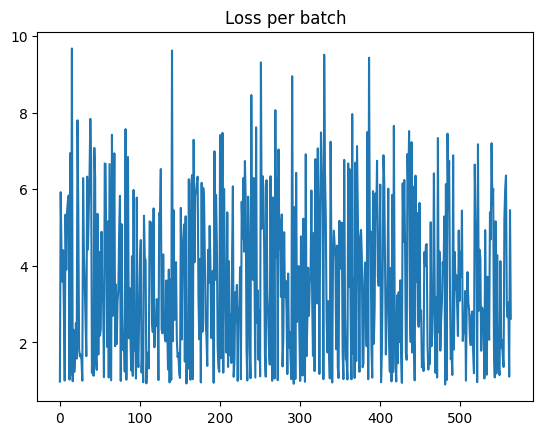

The file ../checkpoints/0802/plots/0802-sh_1qm_losses_epoch_1.png already exists, it will be replaced
Saved in:  ../checkpoints/0802/plots/0802-sh_1qm_losses_epoch_1.png


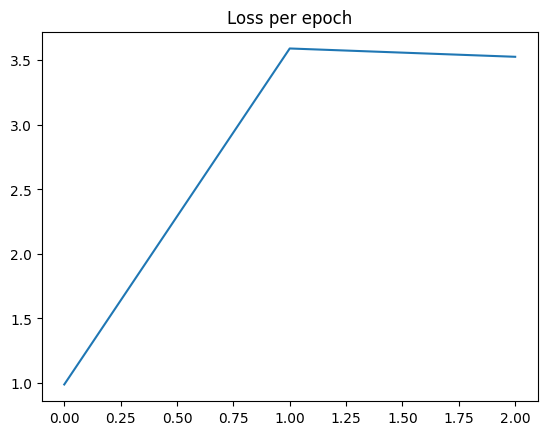

The file ../checkpoints/0802/plots/0802-sh_1qm_losses_epoch_validation_1.png already exists, it will be replaced
Saved in:  ../checkpoints/0802/plots/0802-sh_1qm_losses_epoch_validation_1.png


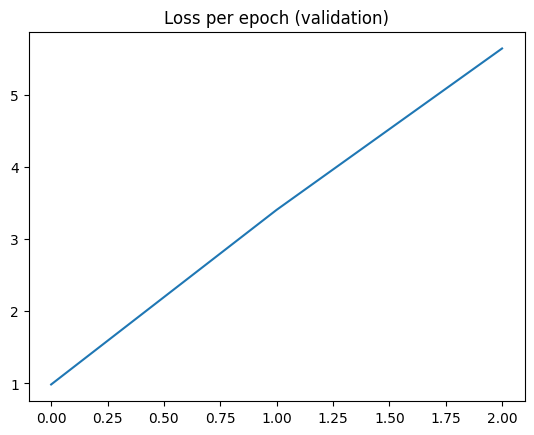

In [37]:
# plot the losses of the trainig loop
model.plot_losses(save=True)

In [19]:
model.save_state_dict()

Model saved as ../checkpoints/0802/models/0802-sh_1qm_1.pth


In [20]:
# push changes to git
!cd peptide-QML && git add . && git commit -m "data trained model" && git push

The system cannot find the path specified.


In [23]:
#load model
model.load_state_dict()

Model loaded from ../checkpoints/0802/models/0802-sh_1qm_1.pth


In [36]:
# print validation
model.print_validation(save=True, precision=10, percentatge=0.01)

i: 0, 		 target: 0.2112450000, 	 output: 0.7398745792, 	 loss: 2.5024477700
i: 1, 		 target: 0.0233710000, 	 output: 0.7398745792, 	 loss: 30.6578057924
i: 2, 		 target: 0.1202440000, 	 output: 0.7398745792, 	 loss: 5.1531101691
i: 3, 		 target: -0.0865190000, 	 output: 0.7398745792, 	 loss: 9.5515849602
i: 4, 		 target: -0.0317880000, 	 output: 0.7398745792, 	 loss: 24.2752793248
i: 5, 		 target: 0.0213940000, 	 output: 0.7398745792, 	 loss: 33.5832747114
i: 6, 		 target: -0.0414390000, 	 output: 0.7398745792, 	 loss: 18.8545471458
i: 7, 		 target: 0.1947140000, 	 output: 0.7398745792, 	 loss: 2.7998016536
i: 8, 		 target: -0.0589970000, 	 output: 0.7398745792, 	 loss: 13.5408847768
i: 9, 		 target: -0.0804390000, 	 output: 0.7398745792, 	 loss: 10.1979584427
Average loss: 0.1511166947
The file ../checkpoints/0802/txts/0802-sh_1qm_validation_1.txt already exists, it will be replaced
